# Import dependencies

In [3]:
from matplotlib import style
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [4]:
import numpy as np
import pandas as pd
import datetime as dt

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session 
from sqlalchemy import create_engine, func , inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect the tables
Base=automap_base()
Base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
Station=Base.classes.station
Measurement=Base.classes.measurement

In [10]:
session=Session(engine)

# Connect to database

In [11]:
# Connect to sqlite database using SQLAlchemy ORM

## Temperature Analysis II

In [12]:
def calc_temps(start_date, end_date):
    """Calculate minimum (TMIN), average (TAVE), and maximum (TMAX) 
        temperatures for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    # TODO: write a function that meets the requirements specified above
    return session.query(func.min(Measurement.tobs), 
                         func.avg(Measurement.tobs), 
                         func.max(Measurement.tobs)).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    
    # function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [13]:
# Using your function, calculate the min, avg, and max for the matching dates
# from the previous year
start_date='2017-08-05'
end_date='2017-08-15'

def calc_temps(start_date,end_date):
    
    return (session.query(func.min(Measurement.tobs), 
                          func.round(
                          func.avg(Measurement.tobs)), 
                          func.max(Measurement.tobs))
                   .filter(Measurement.date >= start_date)
                   .filter(Measurement.date <= end_date)
                   .all())

trip_temp=calc_temps(start_date,end_date)
#print(trip_temp)

trip_temp_df=pd.DataFrame({'start_date': start_date,
                           'end_date': end_date,
                           'min_temp': [trip_temp[0][0]],
                           'avg_temp': [trip_temp[0][1]],
                           'max_temp': [trip_temp[0][2]]
                          })
trip_temp_df.set_index(['start_date','end_date'],inplace=True)
trip_temp_df

,,min_temp,avg_temp,max_temp
start_date,end_date,,,
2017-08-05,2017-08-15,70.0,79.0,84.0


Trip Average Temperature and Error Bar (YEAR)

In [14]:
tavg = [int(result[1]) for result in trip_temp[::]]
tavg

[79]

In [15]:
tmax_tmin=(session.query(func.max(Measurement.tobs) - func.min(Measurement.tobs))
                  .filter(Measurement.date >= start_date)
                  .filter(Measurement.date <= end_date)
                  .all())
    
ptp=list(np.ravel(tmax_tmin))
ptp

[14.0]

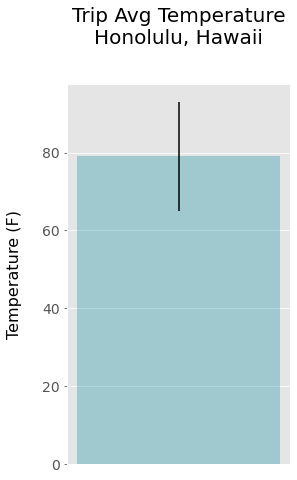

In [25]:
# Plot results as a bar chart per instructions in README
plt.rcParams['figure.figsize']=(4,7)
x_axis = 1
x_ticks = 1

plt.bar(x_axis,tavg, color='xkcd:teal blue', alpha=0.3, width=0.1,align="center",yerr=ptp[0])
plt.xticks(range(x_ticks),[(f'From {start_date} To {end_date}')],fontsize=14,color='black')
plt.title('Trip Avg Temperature\nHonolulu, Hawaii',fontsize=20,pad=40)
plt.ylabel('Temperature (F)',fontsize=16,color='black',labelpad=20)
plt.yticks(fontsize=14)

plt.show()

## Daily Rainfall Average

In [53]:
# Query rainfall per weather station for previous year, sorted by precipitation
# Include station, name, latitude, longitude, and elevation
total_prcp_by_st=(session.query(Measurement.station,Station.name,func.sum(Measurement.prcp),
                                Station.latitude,Station.longitude,Station.elevation)
                         .filter(Measurement.date >= start_date)
                         .filter(Measurement.date <= end_date)
                         .filter(Measurement.station == Station.station)
                         .group_by(Measurement.station)
                         .order_by(func.sum(Measurement.prcp)
                         .desc())
                         .all())

In [54]:
print(f'Daily total rainfall estimates by station for dates between {start_date} and {end_date}.')

total_prcp_by_st_df=pd.DataFrame(total_prcp_by_st,
                                 columns=['station','name',
                                          'total_prcp','latitude',
                                          'longitude','elevation'])
total_prcp_by_st_df

Daily total rainfall estimates by station for dates between 2017-08-05 and 2017-08-15.


,station,name,total_prcp,latitude,longitude,elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",1.39,21.33310,-157.80250,152.4
1,USC00519281,"WAIHEE 837.5, HI US",0.38,21.45167,-157.84889,32.9
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.14,21.33556,-157.71139,19.5
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.11,21.52130,-157.83740,7.0
4,USC00519397,"WAIKIKI 717.2, HI US",0.02,21.27160,-157.81680,3.0


## Daily Temperature Normals

In [59]:
def daily_normals(date):
    """Calculate Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals: tmin, tavg, and tmax
    
    """
    
    # TODO: write a function that meets the requirements specified above
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [61]:
# Calculate the daily normals for each day of your trip (inclusive)

start_date = '2017-08-01'
end_date = '2017-08-07'



trip_dates=['08-05','08-06','08-07','08-08','08-09',
            '08-10','08-11','08-12','08-13','08-14','08-15']

normals=[]
    
def daily_normals(date):
    sel = [func.min(Measurement.tobs), 
           func.round(func.avg(Measurement.tobs),2), 
           func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

for i in trip_dates:
    normals.append(daily_normals(i)[0])

normals

[(69.0, 76.15, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.16, 83.0),
 (68.0, 76.56, 83.0),
 (69.0, 75.98, 81.0),
 (65.0, 76.42, 83.0),
 (67.0, 75.98, 82.0),
 (67.0, 76.53, 83.0),
 (71.0, 76.98, 84.0),
 (71.0, 76.78, 82.0),
 (69.0, 76.47, 83.0)]

In [62]:
# Load results into a dataframe per README instructions
trip_daily_normals_df=pd.DataFrame(normals,columns=['min_temp','avg_temp','max_temp'],
                                   index=trip_dates)

trip_daily_normals_df.index.name='date'
trip_daily_normals_df

,min_temp,avg_temp,max_temp
date,,,
08-05,69.0,76.15,82.0
08-06,67.0,76.25,83.0
08-07,71.0,77.16,83.0
08-08,68.0,76.56,83.0
08-09,69.0,75.98,81.0
08-10,65.0,76.42,83.0
08-11,67.0,75.98,82.0
08-12,67.0,76.53,83.0
08-13,71.0,76.98,84.0


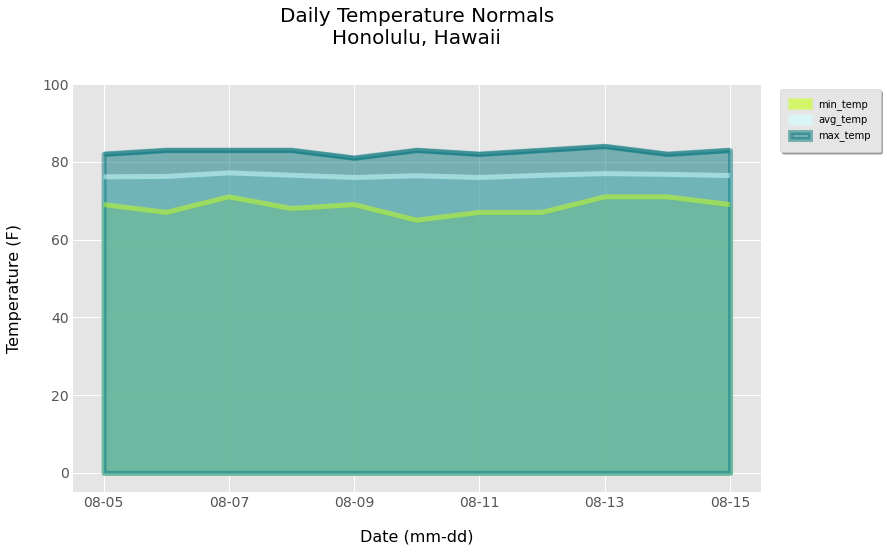

In [63]:
# Plot the daily normals as an area plot with `stacked=False`
plt.rcParams['figure.figsize']=(11,7)
colors=['xkcd:green yellow','xkcd:very light blue','xkcd:deep aqua']
trip_daily_normals_df.plot.area(linewidth=5,stacked=False,rot=0,alpha=0.5,color=colors);

plt.ylim(-5,100)
plt.yticks(size=14)
plt.xticks(fontsize=14)
plt.xlabel('Date (mm-dd)',fontsize=16,color='black',labelpad=20)
plt.ylabel('Temperature (F)',fontsize=16,color='black',labelpad=20)
plt.title('Daily Temperature Normals\nHonolulu, Hawaii',fontsize=20,pad=40)
plt.gca().legend(loc='center left', bbox_to_anchor=(1.02, 0.91),shadow=True,borderpad=1);

## Close Session

In [64]:
session.close()